In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# get mnist dataset
# 70,000 small images of handwritten digits
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

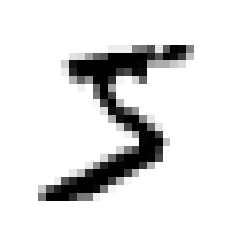

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
# will have to cast labels as integers
y = y.astype(np.uint8)

In [9]:
# this training set is already split into training (first 60,000) and test set (last 10,000).
# already shuffled so all cross-validation folds will be similar
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
X_test.shape

(10000, 784)

In [11]:
# to begin with, just train a classifier to determine if digit is 5 or not 5
y_train_5 = (y_train == 5) # true for all 5s. False for other digits
y_test_5 = (y_test == 5)

In [12]:
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_classifier.predict([some_digit])

array([ True])

In [14]:
# evaluate using cross validation
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# very high accuracy. However accuracy may not be the best metric as only 10% of the data are 5's.
# Simply predicting all numbers are not 5 would give 90% accuracy

In [16]:
# instead try confusion matrix
# returns: True Negatives | False Positives
#          False Negatives | True Positives
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [17]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# try precision, recall, f1 score
# precision = TP / TP + FP. recall = TP / TP + FN. f1 = precision * recall / precision + recall

In [19]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
# can use decision_function() instead of predict() if you want to use any threshold between precision and recall when making predictions

In [23]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores


array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# raises threshold decreases recall

In [27]:
# deciding what threshold to use - can use precision-recall curve
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
                            method="decision_function")

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.grid(b=True)
    plt.legend()

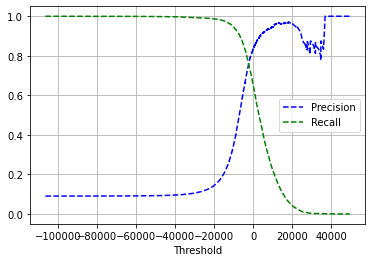

In [30]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
# if you wanted you could aim for a certain precision, e.g. 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [35]:
# easy to get any precision score but it could give you bad recall

In [36]:
# can also use ROC curve - plots true positive rate against false positive rate

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid(b=True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

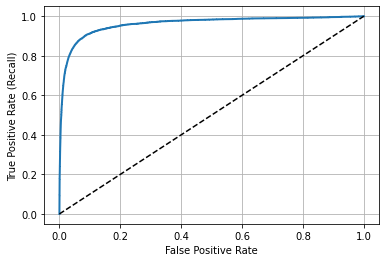

In [39]:
plot_roc_curve(fpr, tpr)
plt.show()

In [40]:
# can compare classifiers using AUC (area under the curve). Perfect will be 1, random will be 0.5
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
# train a random forest and compare to stochastic gradient descent
# random forest has no decision_function() method, has predict_proba() instead
forest_classifier = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:,1] # score = prob of positive
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

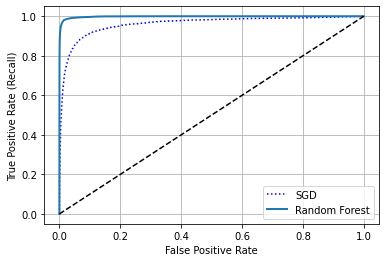

In [43]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
# random forest seems to perform much better
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
# MULTICLASS CLASSIFICATION

In [46]:
# try with Support Vector Machine classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_classifier.predict([some_digit])

array([5], dtype=uint8)

In [47]:
some_digits_scores = svm_classifier.decision_function([some_digit])

In [48]:
np.argmax(some_digits_scores)

5

In [49]:
svm_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
# can force multiclass to use one vs one classifier. SVM can default to one vs rest classifiers
# instead of SVC use OneVsRestClassifier(SVC())

In [51]:
# try multiclass with ramdon forest
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array([3], dtype=uint8)

In [52]:
# SGD doesn't need OvO or OvR as it can directly classify to multiple classes
sgd_classifier.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
# predicts 3 here, which is an error

In [54]:
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [55]:
# try to improve accuracy further by scaling inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [56]:
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [57]:
# ERROR ANALYSIS

In [58]:
# analyse types of errors using confusion matrix
y_train_pred = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

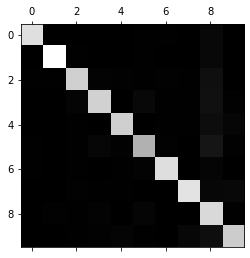

In [59]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [62]:
# on the whole categories seem to be classified correctly. 5 likely to be misclassified more as it is darker

In [60]:
# focus plot on errors
# value / no. of images in class -> gives error rate instead of absolute error
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

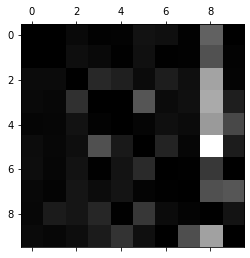

In [61]:
# fill diagonal with 0s to only give the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
# focussing only on errors shows that 8s seem to be incorrect the most

In [64]:
# multilabel classification
# see p106. can use KNeighboursClassifier()